In [22]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler


In [23]:
#technology = "microarray" # "RNAseq"
technology = "RNAseq" #microarray

In [24]:

# Assuming your DataFrame is called cts and has gene expression data
# Assuming cts is a pandas DataFrame with gene expression data
if technology == "microarray":
    cts = pd.read_csv("/home/karen/Documents/phd/Data/trainign_dataset_51270_microarray_unadjusted.csv")
elif technology == "RNAseq":
    cts = pd.read_csv("/home/karen/Documents/GitHub/Test_DEG_methods-single_cell/batch_correction/RNAseq_All_abundances_unadjusted.csv")

metadata =   cts[["Experiment", "Sample", "Age"]]


In [25]:
metadata

,Experiment,Sample,Age
0,GSE164471,SRR13388732,23.0
1,GSE164471,SRR13388733,28.0
2,GSE164471,SRR13388734,31.0
3,GSE164471,SRR13388735,31.0
4,GSE164471,SRR13388736,35.0
...,...,...,...
265,GSE129643,SRR8882198,27.0
266,GSE129643,SRR8882200,33.0
267,GSE129643,SRR8882202,37.0
268,GSE129643,SRR8882203,38.0


# Function

In [26]:
import matplotlib.pyplot as plt

def generate_colors(n):
        colormap = plt.cm.get_cmap('tab20', n)
        colors = [colormap(i) for i in range(n)]
        return colors
    
def blot_expression(subset_data, experiments, count_experiments, colors=None, title=None, save=False):
    
    if colors is None:
        colors = generate_colors(len(experiments))
    colored = np.sum(list(count_experiments.values()))
    if len(subset_data.columns) != colored:
        raise "the columns and the experiments should be same length"
        return None
    if len(count_experiments) != len(experiments):
        raise "the count_experiments and the experiments should be same length"
        return None
    if title is None:
        title = 'Expression of Gene Expression Across Experiments'
    boxes=[]
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    start_c = 0
    end_c = len(subset_data.columns)
    color_i = 0
    for exp in experiments:
        end_c=start_c + count_experiments[exp]
        # Boxplot for the first 84 columns
        box= ax.boxplot(subset_data.iloc[:, start_c:end_c], positions=list(range(start_c+1,end_c+1)), showfliers=False, patch_artist=True,
                          boxprops=dict(facecolor=colors[color_i], color=colors[color_i])
                          )
        start_c = end_c
        boxes.append(box)
        color_i=color_i+1
                          
    
    # Set labels and titles
    ax.set_title(title)
    ax.set_ylabel('Expression')
    
    # Adjust legend
    legends_list = [b["boxes"][0] for b in boxes]
    ax.legend(legends_list, experiments)
    
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()


In [27]:
def two_step_normalization( data: pd.DataFrame):
        """
        Two step normalization from Ivan Izonin et al, 2022.  Two-Step Data Normalization Approach for Improving 
        Classification Accuracy in the Medical Diagnosis Domain.
        1. Max Abs Scaler
        2. L2 normalization
        3. Add norm feature
        4. L2 normalization
        5. Return the normalized dataset
        """
        dataset = data.values
        # Initialize the Max Abs Scaler (step 1)
        scaler = MaxAbsScaler()

        # Fit and transform the data Equation (1)
        dataset = scaler.fit_transform(dataset)
        # Calculate the norm of each vector in the dataset using Equation (2)
        norms = np.sqrt(np.sum(dataset ** 2, axis=1))
        # Apply Equation (3) to calculate the norm of each vector in the dataset
        dataset = np.divide(dataset, norms[:, np.newaxis])
        # add norm feature
        dataset = np.column_stack((dataset, norms))

        
        # let's repeat the scaler
        scaler_2 = StandardScaler()
        dataset = scaler_2.fit_transform(dataset)

        # dataset = np.delete(dataset, -1, axis=1)
        # transform back to dataframe and return
        columns = list(data.columns)
        columns.append('norm')
        return pd.DataFrame(dataset, index=data.index, columns=columns)

In [28]:
cts

,Sample,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.11,...,ENSG00000285472.1,ENSG00000285476.1,ENSG00000285480.1,ENSG00000285491.1,ENSG00000285505.1,ENSG00000285508.1,ENSG00000285509.1,Experiment,Age,Sample.1
0,SRR13388732,3.346531,0.000000,7.023940,0.705439,3.879328,0.275243,7.746350,6.574690,8.136232,...,0.311412,0.439481,0.000000,0.000000,0.000000,4.61464,0.142626,GSE164471,23.0,SRR13388732
1,SRR13388733,7.351350,0.000000,13.916237,4.891812,2.885359,0.190321,16.006573,6.498180,10.725815,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.80200,1.119540,GSE164471,28.0,SRR13388733
2,SRR13388734,7.671751,1.624510,18.720030,3.338030,9.629021,0.204143,19.061782,7.368540,11.420381,...,0.000000,0.167163,0.000000,0.418267,0.000000,2.37204,0.915094,GSE164471,31.0,SRR13388734
3,SRR13388735,2.547355,0.184514,6.876067,0.888782,1.684829,0.000000,3.182537,2.415355,2.242850,...,0.000000,0.148800,0.000000,0.000000,0.000000,5.20632,0.813373,GSE164471,31.0,SRR13388735
4,SRR13388736,15.728966,0.613411,14.120093,3.123864,10.457990,0.198544,12.340000,19.441760,18.223213,...,1.544910,1.069550,0.379249,0.000000,0.000000,3.39066,0.707502,GSE164471,35.0,SRR13388736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,SRR8882198,1.832683,0.000000,2.567454,0.617939,1.599221,0.338734,2.457767,1.825564,5.485286,...,0.043890,0.109543,0.131619,0.115910,0.023606,1.51306,0.347812,GSE129643,27.0,SRR8882198
266,SRR8882200,2.251713,0.000000,2.120141,0.895718,2.379145,0.418938,1.489740,2.676330,1.880811,...,0.000000,0.156295,0.000000,0.078959,0.000000,1.51426,0.129535,GSE129643,33.0,SRR8882200
267,SRR8882202,1.387888,0.057285,5.080017,1.439485,1.263484,0.194929,3.880208,2.066827,5.226251,...,0.000000,0.000000,0.090303,0.000000,0.000000,2.29948,0.106928,GSE129643,37.0,SRR8882202
268,SRR8882203,1.048829,0.000000,3.248294,1.789166,0.405673,0.152905,2.071356,1.466217,3.389388,...,0.000000,0.057207,0.000000,0.000000,0.000295,2.80874,0.115525,GSE129643,38.0,SRR8882203


In [29]:
sample_order = cts["Sample"].tolist()  # Get the order of samples in cts
experiment_order = cts["Experiment"].tolist() 
age_order = cts["Age"].tolist()


In [30]:
df =pd.DataFrame(experiment_order)
count_experiments = dict(df[0].value_counts())
count_experiments
experiments = list(count_experiments)
experiments

['GSE157585', 'GSE167186', 'GSE164471', 'GSE60590', 'GSE129643', 'GSE152558']

In [31]:
def map_to_category(age):
    if age <= 35:
        return "Young"
    elif age > 65:
        return "Old"
    else:
        return "MiddleAge"

# Map values in age_order to categories
age_order = [map_to_category(age) for age in age_order]

In [32]:
cts

,Sample,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.11,...,ENSG00000285472.1,ENSG00000285476.1,ENSG00000285480.1,ENSG00000285491.1,ENSG00000285505.1,ENSG00000285508.1,ENSG00000285509.1,Experiment,Age,Sample.1
0,SRR13388732,3.346531,0.000000,7.023940,0.705439,3.879328,0.275243,7.746350,6.574690,8.136232,...,0.311412,0.439481,0.000000,0.000000,0.000000,4.61464,0.142626,GSE164471,23.0,SRR13388732
1,SRR13388733,7.351350,0.000000,13.916237,4.891812,2.885359,0.190321,16.006573,6.498180,10.725815,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.80200,1.119540,GSE164471,28.0,SRR13388733
2,SRR13388734,7.671751,1.624510,18.720030,3.338030,9.629021,0.204143,19.061782,7.368540,11.420381,...,0.000000,0.167163,0.000000,0.418267,0.000000,2.37204,0.915094,GSE164471,31.0,SRR13388734
3,SRR13388735,2.547355,0.184514,6.876067,0.888782,1.684829,0.000000,3.182537,2.415355,2.242850,...,0.000000,0.148800,0.000000,0.000000,0.000000,5.20632,0.813373,GSE164471,31.0,SRR13388735
4,SRR13388736,15.728966,0.613411,14.120093,3.123864,10.457990,0.198544,12.340000,19.441760,18.223213,...,1.544910,1.069550,0.379249,0.000000,0.000000,3.39066,0.707502,GSE164471,35.0,SRR13388736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,SRR8882198,1.832683,0.000000,2.567454,0.617939,1.599221,0.338734,2.457767,1.825564,5.485286,...,0.043890,0.109543,0.131619,0.115910,0.023606,1.51306,0.347812,GSE129643,27.0,SRR8882198
266,SRR8882200,2.251713,0.000000,2.120141,0.895718,2.379145,0.418938,1.489740,2.676330,1.880811,...,0.000000,0.156295,0.000000,0.078959,0.000000,1.51426,0.129535,GSE129643,33.0,SRR8882200
267,SRR8882202,1.387888,0.057285,5.080017,1.439485,1.263484,0.194929,3.880208,2.066827,5.226251,...,0.000000,0.000000,0.090303,0.000000,0.000000,2.29948,0.106928,GSE129643,37.0,SRR8882202
268,SRR8882203,1.048829,0.000000,3.248294,1.789166,0.405673,0.152905,2.071356,1.466217,3.389388,...,0.000000,0.057207,0.000000,0.000000,0.000295,2.80874,0.115525,GSE129643,38.0,SRR8882203


In [33]:
cts_processed = cts.copy()
#
if technology == "microarray":
    cts_processed.drop(['Age', 'Sex', 'Status', 'Experiment'], axis=1, inplace=True)
elif technology == "RNAseq":
    cts_processed.drop(['Age', 'Sample.1', 'Experiment'], axis=1, inplace=True)
cts_processed.set_index("Sample",  inplace=True)

In [34]:
#!pip install combat

In [35]:
from combat.pycombat import pycombat
data = cts.copy()

# Extract batch information into a separate variable
# Replace 'batch_column_name' with the name of the column containing batch information
batch_info = data['Experiment']
age_list = data["Age"]
# Remove the batch column from the data
if technology == "microarray":
    data.drop(['Age', 'Sex', 'Status', 'Experiment'], axis=1, inplace=True)

elif technology == "RNAseq":
    data.drop(['Age', 'Sample.1', 'Experiment'], axis=1, inplace=True)


data.set_index("Sample", inplace=True)


In [36]:
data= data.T

In [38]:
data

Sample,SRR13388732,SRR13388733,SRR13388734,SRR13388735,SRR13388736,SRR13388737,SRR13388738,SRR13388739,SRR13388740,SRR13388741,...,SRR8882190,SRR8882191,SRR8882192,SRR8882195,SRR8882196,SRR8882198,SRR8882200,SRR8882202,SRR8882203,SRR8882219
ENSG00000000003.14,3.346531,7.351350,7.671751,2.547355,15.728966,2.841494,5.193670,4.153453,4.300594,4.459110,...,13.848931,3.564186,3.274745,2.238637,3.150603,1.832683,2.251713,1.387888,1.048829,2.151968
ENSG00000000005.5,0.000000,0.000000,1.624510,0.184514,0.613411,0.000000,0.000000,0.000000,0.000000,0.543264,...,0.662343,0.000000,0.735241,0.000000,0.249809,0.000000,0.000000,0.057285,0.000000,0.596399
ENSG00000000419.12,7.023940,13.916237,18.720030,6.876067,14.120093,7.675674,19.809370,9.133720,12.253240,12.219568,...,4.632428,13.652944,9.308650,5.111828,6.741798,2.567454,2.120141,5.080017,3.248294,5.567121
ENSG00000000457.13,0.705439,4.891812,3.338030,0.888782,3.123864,0.895387,4.355390,1.706076,4.021705,2.631625,...,4.156385,2.069441,2.928315,2.342587,1.243943,0.617939,0.895718,1.439485,1.789166,2.209411
ENSG00000000460.16,3.879328,2.885359,9.629021,1.684829,10.457990,3.117501,4.168048,2.193944,5.262607,7.334530,...,23.378650,4.354851,3.887155,2.090256,2.319032,1.599221,2.379145,1.263484,0.405673,3.183493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285480.1,0.000000,0.000000,0.000000,0.000000,0.379249,0.816663,2.316580,0.000000,0.000000,0.000000,...,0.000000,0.264335,1.647620,0.000000,0.000000,0.131619,0.000000,0.090303,0.000000,0.000000
ENSG00000285491.1,0.000000,0.000000,0.418267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.120990,0.000000,0.000000,0.000000,0.000000,0.115910,0.078959,0.000000,0.000000,0.625065
ENSG00000285505.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.054416,0.000000,0.000000,0.000000,0.023606,0.000000,0.000000,0.000295,0.079723
ENSG00000285508.1,4.614640,13.802000,2.372040,5.206320,3.390660,5.519160,0.000000,1.975900,4.651560,3.598880,...,1.806360,2.594540,1.859600,1.281800,0.188396,1.513060,1.514260,2.299480,2.808740,0.000000


In [37]:
colors=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']

In [17]:

#blot_expression(data, experiments, count_experiments, colors=colors, save=f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_unalteraded.png")



In [39]:

data = two_step_normalization(data)

/tmp/ipykernel_69888/3692282819.py:20: RuntimeWarning: invalid value encountered in divide
  dataset = np.divide(dataset, norms[:, np.newaxis])


,SRR13388732,SRR13388733,SRR13388734,SRR13388735,SRR13388736,SRR13388737,SRR13388738,SRR13388739,SRR13388740,SRR13388741,...,SRR8882191,SRR8882192,SRR8882195,SRR8882196,SRR8882198,SRR8882200,SRR8882202,SRR8882203,SRR8882219,norm
ENSG00000000003.14,0.180667,1.569911,0.471675,0.842444,0.499633,0.760635,0.660892,1.213944,0.415181,0.750958,...,0.124104,0.324302,0.498964,0.212094,0.384912,0.063323,0.261297,0.167981,-0.117941,-0.035765
ENSG00000000005.5,-0.528096,-0.604642,2.438314,0.632898,-0.266802,-0.520247,-0.455138,-0.533723,-0.677966,1.294786,...,-0.632648,1.782611,-0.500700,0.150900,-0.513310,-0.393127,-0.147540,-0.311282,0.631589,-0.040289
ENSG00000000419.12,-0.340788,-0.086328,-0.477623,0.014172,-0.732989,-0.084587,0.080832,-0.049813,-0.285801,-0.137091,...,-0.267652,-0.267587,-0.213281,-0.294979,-0.354869,-0.339012,-0.158273,-0.124389,-0.349010,-0.001369
ENSG00000000457.13,-0.311679,1.491389,-0.034984,0.221853,-0.490274,0.064406,0.900531,0.506132,0.802796,0.554179,...,0.003812,0.596503,1.014574,-0.085032,-0.074611,-0.130114,0.652263,0.872972,0.049017,-0.037299
ENSG00000000460.16,0.388461,0.347495,1.020050,0.513509,0.140711,1.047463,0.544012,0.496121,0.814305,1.883041,...,0.398838,0.623150,0.540578,0.087941,0.361072,0.144893,0.273418,-0.104486,0.104917,-0.036278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285480.1,-0.528096,-0.604642,-0.898641,-0.412275,-0.795734,0.516190,0.946340,-0.533723,-0.677966,-0.604935,...,-0.474638,0.708243,-0.500700,-0.481987,-0.331695,-0.393127,-0.374379,-0.311282,-0.460638,-0.038960
ENSG00000285491.1,-0.528096,-0.604642,1.478087,-0.412275,-0.890071,-0.520247,-0.455138,-0.533723,-0.677966,-0.604935,...,-0.632648,-0.597519,-0.500700,-0.481987,1.293935,0.116062,-0.516940,-0.311282,2.706004,-0.040564
ENSG00000285505.1,-0.528096,-0.604642,-0.898641,-0.412275,-0.890071,-0.520247,-0.455138,-0.533723,-0.677966,-0.604935,...,2.070127,-0.597519,-0.500700,-0.481987,2.193227,-0.393127,-0.516940,-0.279759,2.509317,-0.040698
ENSG00000285508.1,0.802109,4.952088,-0.321978,3.078021,-0.482334,2.865931,-0.455138,0.597866,0.931283,0.884491,...,0.117122,0.114946,0.278350,-0.425498,0.496005,0.024660,1.237998,1.435565,-0.460638,-0.037079


In [19]:
data.columns

Index(['SRR13388732', 'SRR13388733', 'SRR13388734', 'SRR13388735',
       'SRR13388736', 'SRR13388737', 'SRR13388738', 'SRR13388739',
       'SRR13388740', 'SRR13388741',
       ...
       'SRR8882191', 'SRR8882192', 'SRR8882195', 'SRR8882196', 'SRR8882198',
       'SRR8882200', 'SRR8882202', 'SRR8882203', 'SRR8882219', 'norm'],
      dtype='object', length=271)

In [43]:
data.dropna(inplace=True)
data

Sample,SRR13388732,SRR13388733,SRR13388734,SRR13388735,SRR13388736,SRR13388737,SRR13388738,SRR13388739,SRR13388740,SRR13388741,...,SRR8882190,SRR8882191,SRR8882192,SRR8882195,SRR8882196,SRR8882198,SRR8882200,SRR8882202,SRR8882203,SRR8882219
ENSG00000000003.14,3.346531,7.351350,7.671751,2.547355,15.728966,2.841494,5.193670,4.153453,4.300594,4.459110,...,13.848931,3.564186,3.274745,2.238637,3.150603,1.832683,2.251713,1.387888,1.048829,2.151968
ENSG00000000005.5,0.000000,0.000000,1.624510,0.184514,0.613411,0.000000,0.000000,0.000000,0.000000,0.543264,...,0.662343,0.000000,0.735241,0.000000,0.249809,0.000000,0.000000,0.057285,0.000000,0.596399
ENSG00000000419.12,7.023940,13.916237,18.720030,6.876067,14.120093,7.675674,19.809370,9.133720,12.253240,12.219568,...,4.632428,13.652944,9.308650,5.111828,6.741798,2.567454,2.120141,5.080017,3.248294,5.567121
ENSG00000000457.13,0.705439,4.891812,3.338030,0.888782,3.123864,0.895387,4.355390,1.706076,4.021705,2.631625,...,4.156385,2.069441,2.928315,2.342587,1.243943,0.617939,0.895718,1.439485,1.789166,2.209411
ENSG00000000460.16,3.879328,2.885359,9.629021,1.684829,10.457990,3.117501,4.168048,2.193944,5.262607,7.334530,...,23.378650,4.354851,3.887155,2.090256,2.319032,1.599221,2.379145,1.263484,0.405673,3.183493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285480.1,0.000000,0.000000,0.000000,0.000000,0.379249,0.816663,2.316580,0.000000,0.000000,0.000000,...,0.000000,0.264335,1.647620,0.000000,0.000000,0.131619,0.000000,0.090303,0.000000,0.000000
ENSG00000285491.1,0.000000,0.000000,0.418267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.120990,0.000000,0.000000,0.000000,0.000000,0.115910,0.078959,0.000000,0.000000,0.625065
ENSG00000285505.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.054416,0.000000,0.000000,0.000000,0.023606,0.000000,0.000000,0.000295,0.079723
ENSG00000285508.1,4.614640,13.802000,2.372040,5.206320,3.390660,5.519160,0.000000,1.975900,4.651560,3.598880,...,1.806360,2.594540,1.859600,1.281800,0.188396,1.513060,1.514260,2.299480,2.808740,0.000000


In [44]:
data[data.isna().any(axis=1)]

Sample,SRR13388732,SRR13388733,SRR13388734,SRR13388735,SRR13388736,SRR13388737,SRR13388738,SRR13388739,SRR13388740,SRR13388741,...,SRR8882190,SRR8882191,SRR8882192,SRR8882195,SRR8882196,SRR8882198,SRR8882200,SRR8882202,SRR8882203,SRR8882219


In [67]:
filtered_data = data[(data == 0).all(axis=1)]
data = data.drop(filtered_data.index)
data

Sample,SRR13388732,SRR13388733,SRR13388734,SRR13388735,SRR13388736,SRR13388737,SRR13388738,SRR13388739,SRR13388740,SRR13388741,...,SRR8882190,SRR8882191,SRR8882192,SRR8882195,SRR8882196,SRR8882198,SRR8882200,SRR8882202,SRR8882203,SRR8882219
ENSG00000000003.14,3.346531,7.351350,7.671751,2.547355,15.728966,2.841494,5.193670,4.153453,4.300594,4.459110,...,13.848931,3.564186,3.274745,2.238637,3.150603,1.832683,2.251713,1.387888,1.048829,2.151968
ENSG00000000005.5,0.000000,0.000000,1.624510,0.184514,0.613411,0.000000,0.000000,0.000000,0.000000,0.543264,...,0.662343,0.000000,0.735241,0.000000,0.249809,0.000000,0.000000,0.057285,0.000000,0.596399
ENSG00000000419.12,7.023940,13.916237,18.720030,6.876067,14.120093,7.675674,19.809370,9.133720,12.253240,12.219568,...,4.632428,13.652944,9.308650,5.111828,6.741798,2.567454,2.120141,5.080017,3.248294,5.567121
ENSG00000000457.13,0.705439,4.891812,3.338030,0.888782,3.123864,0.895387,4.355390,1.706076,4.021705,2.631625,...,4.156385,2.069441,2.928315,2.342587,1.243943,0.617939,0.895718,1.439485,1.789166,2.209411
ENSG00000000460.16,3.879328,2.885359,9.629021,1.684829,10.457990,3.117501,4.168048,2.193944,5.262607,7.334530,...,23.378650,4.354851,3.887155,2.090256,2.319032,1.599221,2.379145,1.263484,0.405673,3.183493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285480.1,0.000000,0.000000,0.000000,0.000000,0.379249,0.816663,2.316580,0.000000,0.000000,0.000000,...,0.000000,0.264335,1.647620,0.000000,0.000000,0.131619,0.000000,0.090303,0.000000,0.000000
ENSG00000285491.1,0.000000,0.000000,0.418267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.120990,0.000000,0.000000,0.000000,0.000000,0.115910,0.078959,0.000000,0.000000,0.625065
ENSG00000285505.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.054416,0.000000,0.000000,0.000000,0.023606,0.000000,0.000000,0.000295,0.079723
ENSG00000285508.1,4.614640,13.802000,2.372040,5.206320,3.390660,5.519160,0.000000,1.975900,4.651560,3.598880,...,1.806360,2.594540,1.859600,1.281800,0.188396,1.513060,1.514260,2.299480,2.808740,0.000000


In [92]:
data.fillna(0, inplace=True)

In [45]:
#blot_expression(data, experiments, count_experiments, colors=colors, save=f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_combat_double_normalized.png")

In [68]:
age_list

0      23.0
1      28.0
2      31.0
3      31.0
4      35.0
       ... 
265    27.0
266    33.0
267    37.0
268    38.0
269    72.0
Name: Age, Length: 270, dtype: float64

In [69]:
batch_info

0      GSE164471
1      GSE164471
2      GSE164471
3      GSE164471
4      GSE164471
         ...    
265    GSE129643
266    GSE129643
267    GSE129643
268    GSE129643
269    GSE129643
Name: Experiment, Length: 270, dtype: object

In [70]:
data

Sample,SRR13388732,SRR13388733,SRR13388734,SRR13388735,SRR13388736,SRR13388737,SRR13388738,SRR13388739,SRR13388740,SRR13388741,...,SRR8882190,SRR8882191,SRR8882192,SRR8882195,SRR8882196,SRR8882198,SRR8882200,SRR8882202,SRR8882203,SRR8882219
ENSG00000000003.14,3.346531,7.351350,7.671751,2.547355,15.728966,2.841494,5.193670,4.153453,4.300594,4.459110,...,13.848931,3.564186,3.274745,2.238637,3.150603,1.832683,2.251713,1.387888,1.048829,2.151968
ENSG00000000005.5,0.000000,0.000000,1.624510,0.184514,0.613411,0.000000,0.000000,0.000000,0.000000,0.543264,...,0.662343,0.000000,0.735241,0.000000,0.249809,0.000000,0.000000,0.057285,0.000000,0.596399
ENSG00000000419.12,7.023940,13.916237,18.720030,6.876067,14.120093,7.675674,19.809370,9.133720,12.253240,12.219568,...,4.632428,13.652944,9.308650,5.111828,6.741798,2.567454,2.120141,5.080017,3.248294,5.567121
ENSG00000000457.13,0.705439,4.891812,3.338030,0.888782,3.123864,0.895387,4.355390,1.706076,4.021705,2.631625,...,4.156385,2.069441,2.928315,2.342587,1.243943,0.617939,0.895718,1.439485,1.789166,2.209411
ENSG00000000460.16,3.879328,2.885359,9.629021,1.684829,10.457990,3.117501,4.168048,2.193944,5.262607,7.334530,...,23.378650,4.354851,3.887155,2.090256,2.319032,1.599221,2.379145,1.263484,0.405673,3.183493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285480.1,0.000000,0.000000,0.000000,0.000000,0.379249,0.816663,2.316580,0.000000,0.000000,0.000000,...,0.000000,0.264335,1.647620,0.000000,0.000000,0.131619,0.000000,0.090303,0.000000,0.000000
ENSG00000285491.1,0.000000,0.000000,0.418267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.120990,0.000000,0.000000,0.000000,0.000000,0.115910,0.078959,0.000000,0.000000,0.625065
ENSG00000285505.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.054416,0.000000,0.000000,0.000000,0.023606,0.000000,0.000000,0.000295,0.079723
ENSG00000285508.1,4.614640,13.802000,2.372040,5.206320,3.390660,5.519160,0.000000,1.975900,4.651560,3.598880,...,1.806360,2.594540,1.859600,1.281800,0.188396,1.513060,1.514260,2.299480,2.808740,0.000000


In [71]:
data_corrected = pycombat(data=data,batch=batch_info, mod=[], precision=0.1)

Found 6 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


/home/karen/anaconda3/lib/python3.11/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data


In [72]:
data_corrected

Sample,SRR13388732,SRR13388733,SRR13388734,SRR13388735,SRR13388736,SRR13388737,SRR13388738,SRR13388739,SRR13388740,SRR13388741,...,SRR8882190,SRR8882191,SRR8882192,SRR8882195,SRR8882196,SRR8882198,SRR8882200,SRR8882202,SRR8882203,SRR8882219
ENSG00000000003.14,3.132408,5.807776,6.021815,2.598529,11.404334,2.795024,4.366365,3.671462,3.769757,3.875652,...,8.884809,2.691569,2.517275,1.893354,2.442519,1.648898,1.901228,1.381052,1.176879,1.841164
ENSG00000000005.5,-0.045581,-0.045581,1.556082,0.136338,0.559203,-0.045581,-0.045581,-0.045581,-0.045581,0.490042,...,0.505844,-0.038617,0.565768,-0.038617,0.166732,-0.038617,-0.038617,0.008472,-0.038617,0.451637
ENSG00000000419.12,14.523558,17.848787,20.166406,14.452216,17.947139,14.837991,20.691964,15.541434,17.046465,17.030220,...,12.371953,16.711651,14.621646,12.602588,13.386754,11.378510,11.163312,12.587284,11.706057,12.821626
ENSG00000000457.13,0.839182,3.484670,2.502791,0.955041,2.367453,0.959215,3.145690,1.471512,2.934825,2.056394,...,2.779890,1.576499,2.071750,1.734002,1.100493,0.739522,0.899697,1.213248,1.414884,1.657210
ENSG00000000460.16,2.024084,1.434711,5.433363,0.722857,5.924899,1.572359,2.195281,1.024737,2.844299,4.072845,...,12.131526,1.907423,1.656065,0.690344,0.813298,0.426444,0.845605,0.246006,-0.215014,1.277891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285480.1,0.334762,0.334762,0.334762,0.334762,0.744176,1.216381,2.835600,0.334762,0.334762,0.334762,...,0.333574,0.538125,1.608555,0.333574,0.333574,0.435425,0.333574,0.403454,0.333574,0.333574
ENSG00000285491.1,-0.011704,-0.011704,0.249925,-0.011704,-0.011704,-0.011704,-0.011704,-0.011704,-0.011704,-0.011704,...,0.555206,-0.012101,-0.012101,-0.012101,-0.012101,0.046558,0.027858,-0.012101,-0.012101,0.304230
ENSG00000285505.1,-0.000846,-0.000846,-0.000846,-0.000846,-0.000846,-0.000846,-0.000846,-0.000846,-0.000846,-0.000846,...,-0.001307,0.034397,-0.001307,-0.001307,-0.001307,0.014182,-0.001307,-0.001307,-0.001114,0.051001
ENSG00000285508.1,5.050186,13.306445,3.034865,5.581902,3.950252,5.863037,0.903221,2.678872,5.083365,4.137369,...,2.122156,2.713761,2.162117,1.728423,0.907717,1.902006,1.902906,2.492290,2.874539,0.766308


In [73]:
data_corrected[data_corrected.isna().any(axis=1)]


Sample,SRR13388732,SRR13388733,SRR13388734,SRR13388735,SRR13388736,SRR13388737,SRR13388738,SRR13388739,SRR13388740,SRR13388741,...,SRR8882190,SRR8882191,SRR8882192,SRR8882195,SRR8882196,SRR8882198,SRR8882200,SRR8882202,SRR8882203,SRR8882219


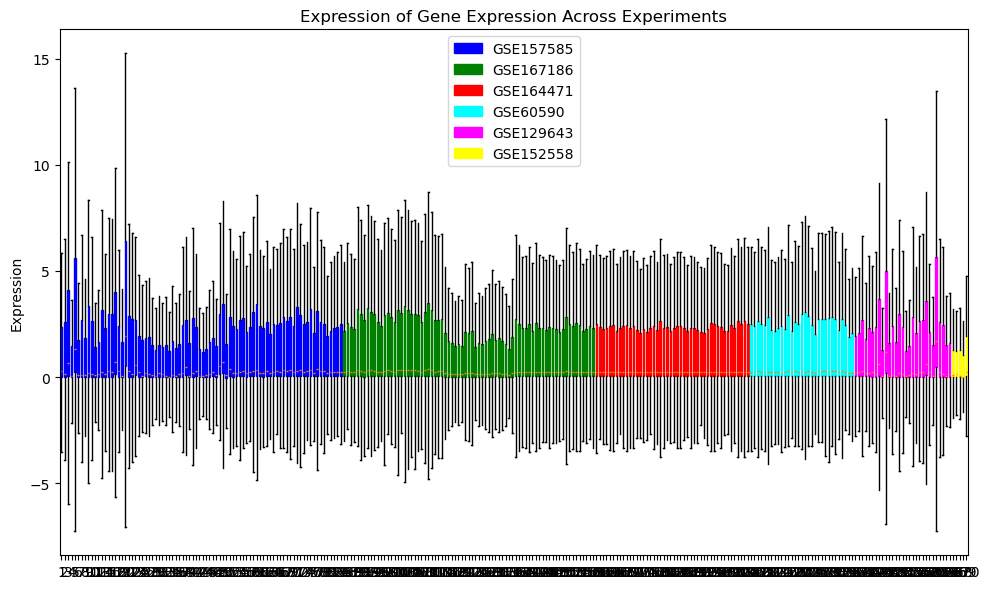

In [74]:
blot_expression(data_corrected, experiments, count_experiments, colors=colors, save=f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_adjustedCombat_double_norm.png")

In [52]:
#blot_expression(data_corrected, experiments, count_experiments, colors=["blue", "green", "orange", "pink","red","purple"])

In [75]:
data_corrected = data_corrected.T

# Testing batch correction

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Set significance threshold (alpha level)

def plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05):
    # Plot histograms of p-values before and after batch correction
    plt.figure(figsize=(10, 5))
    plt.hist(p_values_before, bins=50, color='blue', alpha=0.5, label='Before Correction')
    plt.hist(p_values_after, bins=50, color='green', alpha=0.5, label='After Correction')
    plt.axvline(alpha, color='red', linestyle='--', label='Significance Threshold')
    plt.xlabel('p-value')
    plt.ylabel('Frequency')
    plt.title('Distribution of p-values before and after batch correction')
    plt.legend()
    plt.show()
    
    # Perform Kolmogorov-Smirnov test to compare distributions of p-values
    ks_stat, ks_p_value = ks_2samp(p_values_before, p_values_after)
    print("Kolmogorov-Smirnov test p-value:", ks_p_value)
    
    # Check if more p-values fall below the significance threshold after batch correction
    num_sig_before = np.sum(p_values_before < alpha)
    num_sig_after = np.sum(p_values_after < alpha)
    
    print("Number of significant p-values before correction:", num_sig_before)
    print("Number of significant p-values after correction:", num_sig_after)

def see_distribution(p_values_before, p_values_after):

    # Plot histograms of p-values before and after batch correction
    plt.figure(figsize=(10, 5))
    sns.histplot(p_values_before, bins=50, color='blue', kde=True, label='Before Correction')
    sns.histplot(p_values_after, bins=50, color='green', kde=True, label='After Correction')
    plt.axvline(alpha, color='red', linestyle='--', label='Significance Threshold')
    plt.xlabel('p-value')
    plt.ylabel('Density')
    plt.title('Distribution of p-values before and after batch correction')
    plt.legend()
    plt.show()


In [77]:
def get_ks_values_before_after(data, data_corrected, experiment_1, experiment_2):
    data_before = data.copy()
    data_before = data_before.T
    data_before.reset_index(drop=True, inplace=True)
    
    group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)
    ks_stat_before, ks_p_value_before = ks_2samp(group_a_samples_before, group_b_samples_before)

    data_corrected.reset_index(drop=True, inplace=True)

    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    _, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)
    ks_stat_after, ks_p_value_after = ks_2samp(group_a_samples_corrected, group_b_samples_corrected)

    return ks_p_value_before, ks_p_value_after




In [78]:
def get_p_values_before_after(data, data_corrected, experiment_1, experiment_2):
    data_before = data.copy()
    data_before = data_before.T
    data_before.reset_index(drop=True, inplace=True)
    
    group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)

    data_corrected.reset_index(drop=True, inplace=True)

    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    _, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)

    return p_values_before, p_values_after

In [79]:
experiment_list = experiments
experiments

['GSE157585', 'GSE167186', 'GSE164471', 'GSE60590', 'GSE129643', 'GSE152558']

In [80]:
experiment_1 = experiments[0]
experiment_2 = experiments[1]

In [81]:
# Perform differential expression analysis after batch correction



In [82]:
p_values_before, p_values_after = get_p_values_before_after(data, data_corrected, experiment_1, experiment_2)

/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [83]:
p_values_before

array([4.00100799e-04, 2.31869904e-01, 2.81222006e-75, ...,
       1.96880087e-02, 2.60933994e-32, 8.57392522e-19])

In [84]:
p_values_after

array([9.47998315e-01, 9.46398799e-01, 7.32968211e-06, ...,
       9.79886897e-01, 3.36936832e-01, 9.42564600e-01])

In [85]:
#plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)


In [86]:
p_values_after

array([9.47998315e-01, 9.46398799e-01, 7.32968211e-06, ...,
       9.79886897e-01, 3.36936832e-01, 9.42564600e-01])

## Getting all the experiments p_values


In [87]:
import itertools


In [93]:
expriments_pvalue_before=[]
expriments_pvalue_after=[]
combination_list = []
ks_stats =  []

for experiment_1, experiment_2 in itertools.combinations(experiment_list, 2):
    combination_list.append(f"{experiment_1}-{experiment_2}")
    p_values_before, p_values_after = get_p_values_before_after(data, data_corrected, experiment_1, experiment_2)
    expriments_pvalue_before.append(p_values_before)
    expriments_pvalue_after.append(p_values_after)
    ks_stat, ks_p_value = ks_2samp(p_values_before, p_values_after)
    ks_stats.append({"combination":f"{experiment_1}-{experiment_2}","ks_stat":ks_stat, "ks_pvalue": ks_p_value})



/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stat

In [94]:
# Convert lists to arrays
expriments_pvalue_before_array = np.array(expriments_pvalue_before)
expriments_pvalue_after_array = np.array(expriments_pvalue_after)

# Calculate average and standard deviation for p-values before and after
avg_p_values_before = np.mean(expriments_pvalue_before_array, axis=1)
std_p_values_before = np.std(expriments_pvalue_before_array, axis=1)
avg_p_values_after = np.mean(expriments_pvalue_after_array, axis=1)
std_p_values_after = np.std(expriments_pvalue_after_array, axis=1)

# Create DataFrame for KS test results
ks_stats_df = pd.DataFrame(ks_stats)


# Add columns for average and standard deviation of p-values before and after
ks_stats_df["avg_p_values_before"] = avg_p_values_before
ks_stats_df["std_p_values_before"] = std_p_values_before
ks_stats_df["avg_p_values_after"] = avg_p_values_after
ks_stats_df["std_p_values_after"] = std_p_values_after


In [95]:
ks_stats_df.drop(columns=["ks_stat", "ks_pvalue"])

,combination,avg_p_values_before,std_p_values_before,avg_p_values_after,std_p_values_after
0,GSE157585-GSE167186,NaN,NaN,0.726578,0.374917
1,GSE157585-GSE164471,NaN,NaN,0.771156,0.263740
2,GSE157585-GSE60590,NaN,NaN,0.777155,0.341851
3,GSE157585-GSE129643,NaN,NaN,0.726607,0.281041
4,GSE157585-GSE152558,NaN,NaN,0.624491,0.329743
5,GSE167186-GSE164471,NaN,NaN,0.780523,0.244648
6,GSE167186-GSE60590,NaN,NaN,0.582453,0.429772
7,GSE167186-GSE129643,NaN,NaN,0.713354,0.281439
8,GSE167186-GSE152558,NaN,NaN,0.524614,0.366726
9,GSE164471-GSE60590,NaN,NaN,0.789233,0.261367


In [96]:
ks_stats_df.to_csv(f"ttstat_difference_{technology}_experiments_before_after_combat_double_norm.csv")

Heatmap the similarity of the experiments

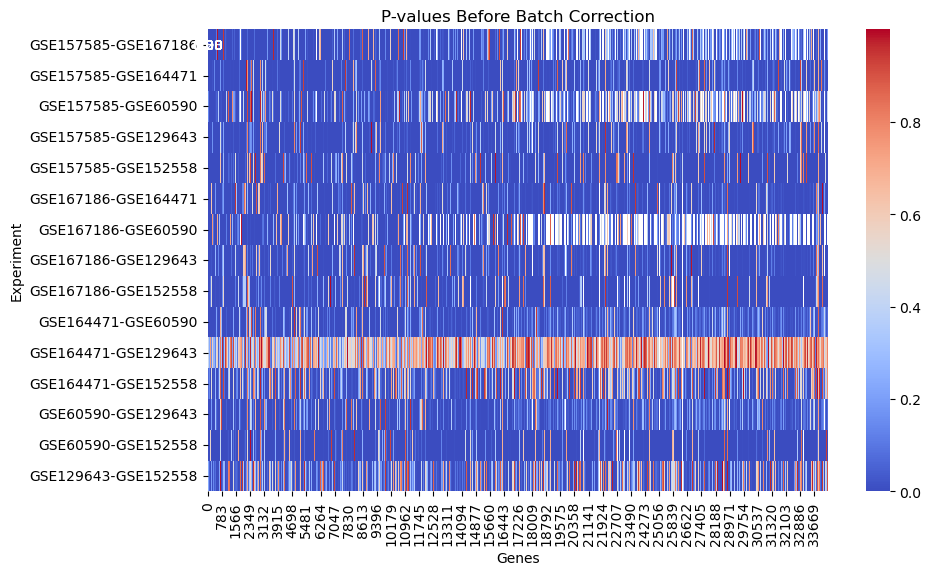

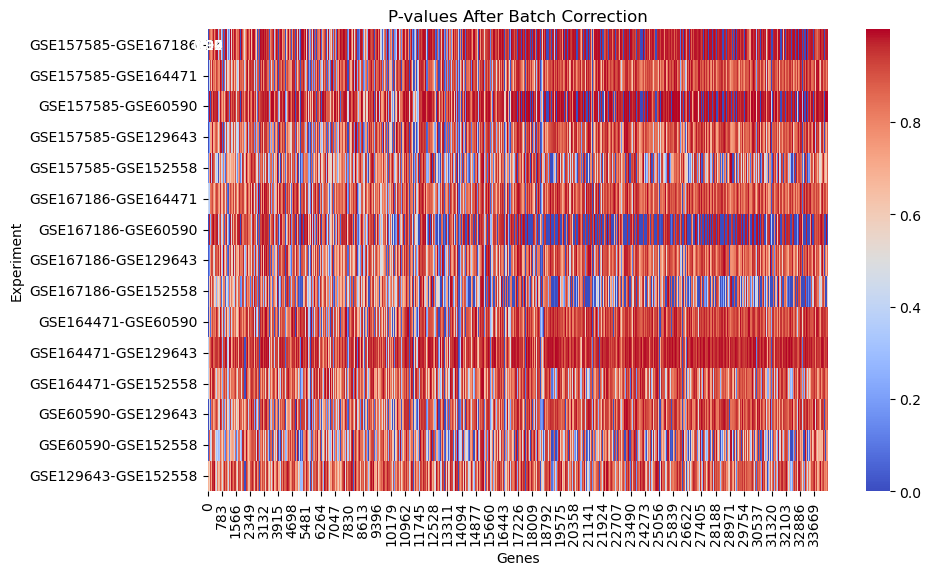

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert lists of p-values to a 2D NumPy array
p_values_before_array = np.array(expriments_pvalue_before)
p_values_after_array = np.array(expriments_pvalue_after)

# Create a heatmap for p-values before batch correction
plt.figure(figsize=(10, 6))
sns.heatmap(p_values_before_array, cmap='coolwarm', annot=True, fmt=".2f", yticklabels=combination_list)
plt.title('P-values Before Batch Correction')
plt.xlabel('Genes')
plt.ylabel('Experiment')
plt.savefig(f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_heatmap_before_double_norm.png")
plt.show()

# Create a heatmap for p-values after batch correction
plt.figure(figsize=(10, 6))
sns.heatmap(p_values_after_array, cmap='coolwarm', annot=True, fmt=".2f", yticklabels=combination_list)
plt.title('P-values After Batch Correction')
plt.xlabel('Genes')
plt.ylabel('Experiment')
plt.savefig(f"/home/karen/Documents/phd/Plots/expression_distribution_{technology}_heatmap_after_double_norm.png")
plt.show()

### Looking with the DE genes only

DE only in one experiment

In [103]:
import pandas as pd
experiment="GSE157585"

def get_columns_to_keep_one(experiment):
    # Path to the CSV file
    file_path = f'/home/karen/Documents/phd/Data/Expression_data/Differential Expression/{experiment}_DDS.csv'
    
    # Read the CSV file
    de_genes = pd.read_csv(file_path, index_col=0)
    
    # Filter rows based on condition
    filtered_data = de_genes[(abs(de_genes['log2FoldChange']) > 1) & (de_genes['padj'] < 0.1)]
    
    # Extract column names from filtered data
    columns_to_keep = filtered_data["row"].str.strip().tolist()
    return columns_to_keep

# Assuming p_values_before is another DataFrame you want to filter columns from
# Replace p_values_before with your DataFrame name
#filtered_columns = p_values_before[columns_to_keep]

# Now you can work with the filtered columns DataFrame as needed


In [104]:
if technology =="RNAseq":
    columns_to_keep = get_columns_to_keep_one(experiment)

In [ ]:
if technology =="RNAseq":
    len(columns_to_keep)

In [ ]:
#filter_Bools = [(abs(de_genes['log2FoldChange']) > 1) & (de_genes['padj'] < 0.1)][0]

In [ ]:
#p_values_after[x]

/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


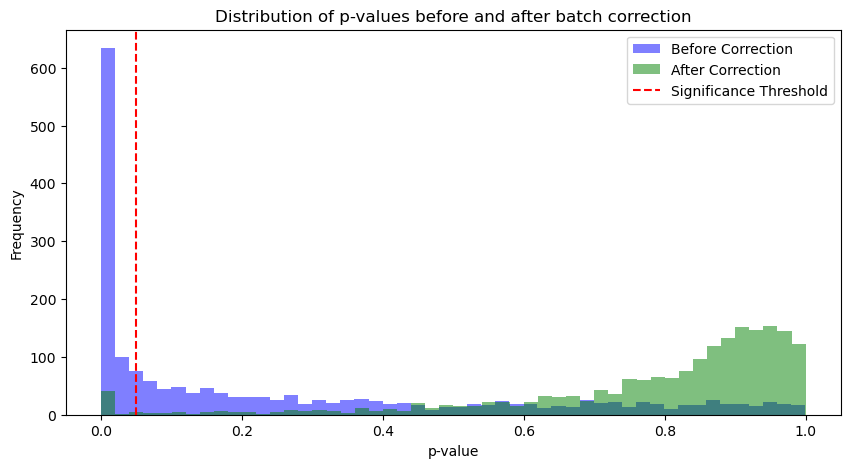

Kolmogorov-Smirnov test p-value: 0.0
Number of significant p-values before correction: 775
Number of significant p-values after correction: 43


In [105]:
if technology =="RNAseq":

    DE_data = data.copy()
    DE_data_corrected = data_corrected.copy()
    
    DE_data= DE_data.T
    DE_data = DE_data[columns_to_keep]
    DE_data_corrected = DE_data_corrected[columns_to_keep]
    DE_data= DE_data.T
    
    p_values_before, p_values_after = get_p_values_before_after(DE_data, DE_data_corrected, experiment_1, experiment_2)
    plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)


In [106]:
if technology =="RNAseq":
    DE_data_corrected

In [107]:
if technology =="RNAseq":
    DE_data

In [108]:
if technology =="RNAseq":
    DE_data.columns

/home/karen/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


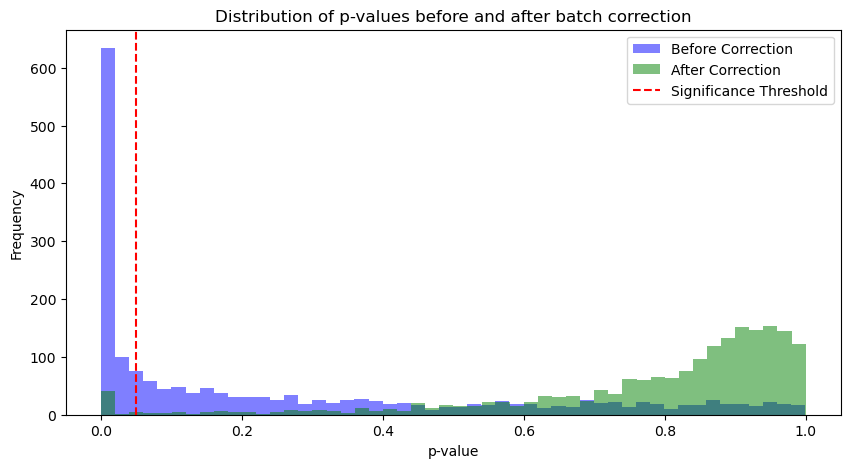

Kolmogorov-Smirnov test p-value: 0.0
Number of significant p-values before correction: 775
Number of significant p-values after correction: 43


In [109]:
if technology =="RNAseq":

    
    data_before = data.copy()
    data_before = data_before.T
    
    data_before.reset_index(drop=True, inplace=True)
    
    group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    group_a_samples_before.columns=data.index
    group_b_samples_before.columns=data.index
    group_a_samples_before = group_a_samples_before[columns_to_keep]
    group_b_samples_before = group_b_samples_before[columns_to_keep]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)
    
    
    data_corrected.reset_index(drop=True, inplace=True)
    
    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    
    group_a_samples_corrected.columns=data.index
    group_b_samples_corrected.columns=data.index
    group_a_samples_corrected = group_a_samples_corrected[columns_to_keep]
    group_b_samples_corrected = group_b_samples_corrected[columns_to_keep]
    t_statistic, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)
    plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)


## Checking random genes

In [110]:
import random
if technology =="RNAseq":
    random_values = random.sample(de_genes["row"].tolist(), len(columns_to_keep))


NameError: name 'de_genes' is not defined

In [ ]:
if technology =="RNAseq":
    
    data_before = data.copy()
    data_before = data_before.T
    
    data_before.reset_index(drop=True, inplace=True)
    
    group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    group_a_samples_before.columns=data.index
    group_b_samples_before.columns=data.index
    group_a_samples_before = group_a_samples_before[random_values]
    group_b_samples_before = group_b_samples_before[random_values]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)
    
    
    data_corrected.reset_index(drop=True, inplace=True)
    
    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    
    group_a_samples_corrected.columns=data.index
    group_b_samples_corrected.columns=data.index
    group_a_samples_corrected = group_a_samples_corrected[random_values]
    group_b_samples_corrected = group_b_samples_corrected[random_values]
    t_statistic, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)
    plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)

## checking DE in both groups

In [ ]:
import pandas as pd
if technology =="RNAseq":
    
    # Path to the CSV file
    file_path_1 = f'/home/karen/Documents/phd/Data/Expression_data/Differential Expression/{experiment_1}_DDS.csv'
    file_path_2 = f'/home/karen/Documents/phd/Data/Expression_data/Differential Expression/{experiment_2}_DDS.csv'
    
    # Read the CSV file
    de_genes_1 = pd.read_csv(file_path_1, index_col=0)
    de_genes_2 = pd.read_csv(file_path_2, index_col=0)
    
    # Filter rows based on condition
    filtered_data_1 = de_genes_1[(abs(de_genes_1['log2FoldChange']) > 1) & (de_genes_1['padj'] < 0.1)]
    filtered_data_2 = de_genes_2[(abs(de_genes_2['log2FoldChange']) > 1) & (de_genes_2['padj'] < 0.1)]
    
    union_filter = pd.concat([filtered_data_1, filtered_data_2]).drop_duplicates()
    intersection_filter = pd.merge(filtered_data_1, filtered_data_2, on='row', how='inner')
    
    # Extract column names from filtered data
    union_keep = union_filter["row"].str.strip().tolist()
    intersection_keep = intersection_filter["row"].str.strip().tolist()


In [ ]:
if technology =="RNAseq":
    
    
    data_before = data.copy()
    data_before = data_before.T
    
    data_before.reset_index(drop=True, inplace=True)
    
    group_a_samples_before = data_before[cts['Experiment'] == experiment_1]
    
    group_b_samples_before = data_before[cts['Experiment'] == experiment_2]
    group_a_samples_before.columns=data.index
    group_b_samples_before.columns=data.index
    group_a_samples_before = group_a_samples_before[intersection_keep]
    group_b_samples_before = group_b_samples_before[intersection_keep]
    _, p_values_before = ttest_ind(group_a_samples_before, group_b_samples_before)
    
    
    data_corrected.reset_index(drop=True, inplace=True)
    
    group_a_samples_corrected = data_corrected[cts['Experiment'] == experiment_1]
    group_b_samples_corrected = data_corrected[cts['Experiment'] == experiment_2]
    
    group_a_samples_corrected.columns=data.index
    group_b_samples_corrected.columns=data.index
    group_a_samples_corrected = group_a_samples_corrected[intersection_keep]
    group_b_samples_corrected = group_b_samples_corrected[intersection_keep]
    t_statistic, p_values_after = ttest_ind(group_a_samples_corrected, group_b_samples_corrected)
    plot_batch_correction_p_values(p_values_before, p_values_after, alpha = 0.05)

Checking the same experiment before and after

In [ ]:
if technology =="RNAseq":
    
    t_statistic, p_values_a = ttest_ind(group_a_samples_before, group_a_samples_corrected)
    t_statistic, p_values_b = ttest_ind(group_b_samples_before, group_b_samples_corrected)
    plot_batch_correction_p_values(p_values_a, p_values_b, alpha = 0.05)

# Cluster data before and after

In [111]:
metadata_short =  pd.DataFrame({
    'Experiment': experiment_order,
    'Age': age_order,
    'Sample': sample_order
})
metadata_short.set_index('Sample', inplace=True)
metadata_short

,Experiment,Age
Sample,,
SRR13388732,GSE164471,Young
SRR13388733,GSE164471,Young
SRR13388734,GSE164471,Young
SRR13388735,GSE164471,Young
SRR13388736,GSE164471,Young
...,...,...
SRR8882198,GSE129643,Young
SRR8882200,GSE129643,Young
SRR8882202,GSE129643,MiddleAge


In [112]:
data_corrected.index = cts["Sample"]

In [113]:
adjuested_data_full = pd.concat([data_corrected, metadata_short], axis=1)

In [114]:
unadjested_data_full= pd.concat([cts_processed, metadata_short], axis=1)

In [115]:
adjuested_data_full.columns[10:]

Index(['ENSG00000001460.17', 'ENSG00000001461.16', 'ENSG00000001497.16',
       'ENSG00000001617.11', 'ENSG00000001626.14', 'ENSG00000001629.9',
       'ENSG00000001630.15', 'ENSG00000001631.15', 'ENSG00000002016.17',
       'ENSG00000002079.14',
       ...
       'ENSG00000285471.1', 'ENSG00000285472.1', 'ENSG00000285476.1',
       'ENSG00000285480.1', 'ENSG00000285491.1', 'ENSG00000285505.1',
       'ENSG00000285508.1', 'ENSG00000285509.1', 'Experiment', 'Age'],
      dtype='object', length=34402)

In [116]:
cts_2 = cts.set_index("Sample")
cts_2

,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.11,ENSG00000001167.14,...,ENSG00000285472.1,ENSG00000285476.1,ENSG00000285480.1,ENSG00000285491.1,ENSG00000285505.1,ENSG00000285508.1,ENSG00000285509.1,Experiment,Age,Sample.1
Sample,,,,,,,,,,,,,,,,,,,,,
SRR13388732,3.346531,0.000000,7.023940,0.705439,3.879328,0.275243,7.746350,6.574690,8.136232,3.166290,...,0.311412,0.439481,0.000000,0.000000,0.000000,4.61464,0.142626,GSE164471,23.0,SRR13388732
SRR13388733,7.351350,0.000000,13.916237,4.891812,2.885359,0.190321,16.006573,6.498180,10.725815,7.545120,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.80200,1.119540,GSE164471,28.0,SRR13388733
SRR13388734,7.671751,1.624510,18.720030,3.338030,9.629021,0.204143,19.061782,7.368540,11.420381,6.801920,...,0.000000,0.167163,0.000000,0.418267,0.000000,2.37204,0.915094,GSE164471,31.0,SRR13388734
SRR13388735,2.547355,0.184514,6.876067,0.888782,1.684829,0.000000,3.182537,2.415355,2.242850,1.916299,...,0.000000,0.148800,0.000000,0.000000,0.000000,5.20632,0.813373,GSE164471,31.0,SRR13388735
SRR13388736,15.728966,0.613411,14.120093,3.123864,10.457990,0.198544,12.340000,19.441760,18.223213,3.726510,...,1.544910,1.069550,0.379249,0.000000,0.000000,3.39066,0.707502,GSE164471,35.0,SRR13388736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR8882198,1.832683,0.000000,2.567454,0.617939,1.599221,0.338734,2.457767,1.825564,5.485286,2.604403,...,0.043890,0.109543,0.131619,0.115910,0.023606,1.51306,0.347812,GSE129643,27.0,SRR8882198
SRR8882200,2.251713,0.000000,2.120141,0.895718,2.379145,0.418938,1.489740,2.676330,1.880811,0.663090,...,0.000000,0.156295,0.000000,0.078959,0.000000,1.51426,0.129535,GSE129643,33.0,SRR8882200
SRR8882202,1.387888,0.057285,5.080017,1.439485,1.263484,0.194929,3.880208,2.066827,5.226251,2.951940,...,0.000000,0.000000,0.090303,0.000000,0.000000,2.29948,0.106928,GSE129643,37.0,SRR8882202


In [117]:
adjuested_data_full["Age"]=cts_2["Age"]
adjuested_data_full

,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.11,ENSG00000001167.14,...,ENSG00000285471.1,ENSG00000285472.1,ENSG00000285476.1,ENSG00000285480.1,ENSG00000285491.1,ENSG00000285505.1,ENSG00000285508.1,ENSG00000285509.1,Experiment,Age
Sample,,,,,,,,,,,,,,,,,,,,,
SRR13388732,3.132408,-0.045581,14.523558,0.839182,2.024084,0.360780,6.608253,4.912554,5.268779,2.194207,...,0.100872,0.172225,0.254502,0.334762,-0.011704,-0.000846,5.050186,0.058399,GSE164471,23.0
SRR13388733,5.807776,-0.045581,17.848787,3.484670,1.434711,0.277194,12.391707,4.864486,6.751811,4.612755,...,-0.005684,-0.013429,-0.015649,0.334762,-0.011704,-0.000846,13.306445,0.537983,GSE164471,28.0
SRR13388734,6.021815,1.556082,20.166406,2.502791,5.433363,0.290799,14.530833,5.411295,7.149584,4.202265,...,0.942689,-0.013429,0.087107,0.334762,0.249925,-0.000846,3.034865,0.437617,GSE164471,31.0
SRR13388735,2.598529,0.136338,14.452216,0.955041,0.722857,0.089867,3.412867,2.299428,1.893688,1.503803,...,-0.005684,-0.013429,0.075819,0.334762,-0.011704,-0.000846,5.581902,0.387681,GSE164471,31.0
SRR13388736,11.404334,0.559203,17.947139,2.367453,5.924899,0.285287,9.824530,12.996366,11.045509,2.503632,...,0.656696,0.907597,0.641808,0.744176,-0.011704,-0.000846,3.950252,0.335707,GSE164471,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR8882198,1.648898,-0.038617,11.378510,0.739522,0.426444,0.407171,1.892053,1.478046,3.106894,1.585903,...,-0.003580,0.004374,0.038608,0.435425,0.046558,0.014182,1.902006,0.122735,GSE129643,27.0
SRR8882200,1.901228,-0.038617,11.163312,0.899697,0.845605,0.466944,1.240763,1.958855,1.154011,0.569187,...,0.029346,-0.017264,0.063804,0.333574,0.027858,-0.001307,1.902906,0.008153,GSE129643,33.0
SRR8882202,1.381052,0.008472,12.587284,1.213248,0.246006,0.300000,2.849074,1.614395,2.966550,1.767917,...,-0.003580,-0.017264,-0.020428,0.403454,-0.012101,-0.001307,2.492290,-0.003714,GSE129643,37.0


In [118]:
adjuested_data_full.to_csv(f"/home/karen/Documents/GitHub/Test_DEG_methods-single_cell/batch_correction/{technology}_abundances_adjusted_combat_double_norm.csv")

In [ ]:
#unadjested_data_full.to_csv(f"/home/karen/Documents/GitHub/Test_DEG_methods-single_cell/batch_correction/{technology}_All_abundances_unadjusted_2.csv")

Looking at reCombat plotting

In [119]:
X = data_corrected.fillna(0, inplace=False).values 

In [120]:
X

array([[ 3.13240786e+00, -4.55813231e-02,  1.45235581e+01, ...,
        -8.46336866e-04,  5.05018620e+00,  5.83989813e-02],
       [ 5.80777572e+00, -4.55813231e-02,  1.78487875e+01, ...,
        -8.46336866e-04,  1.33064450e+01,  5.37983333e-01],
       [ 6.02181549e+00,  1.55608222e+00,  2.01664057e+01, ...,
        -8.46336866e-04,  3.03486450e+00,  4.37617177e-01],
       ...,
       [ 1.38105232e+00,  8.47183999e-03,  1.25872843e+01, ...,
        -1.30702078e-03,  2.49228993e+00, -3.71399456e-03],
       [ 1.17687859e+00, -3.86173910e-02,  1.17060571e+01, ...,
        -1.11353071e-03,  2.87453887e+00,  7.99094229e-04],
       [ 1.84116408e+00,  4.51636871e-01,  1.28216259e+01, ...,
         5.10014886e-02,  7.66307521e-01,  1.37145147e-01]])

In [121]:

# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(experiment_order)}
if technology =="RNAseq":
    category_map = {'GSE164471': -1, 'GSE152558': 0, 'GSE157585': 1, 'GSE167186':2, "GSE60590":3, "GSE129643":4}
elif technology == "microarray":
    category_map = {'GSE13070':-6, 'GSE47969':-5, 'GSE48278':-4, 'GSE9103':-3, 'GSE59880':-2, 'GSE9676':-1, 'GSE161643':0, 'GSE8157':1, 'GSE1428':2, 'GSE38718':3, 'GSE6348':4, 'GSE40551':5, 'GSE87105':6, 'GSE674_2':7}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_experiment_order = [category_map[experiment] for experiment in experiment_order]

from matplotlib.colors import ListedColormap
tab20_colors = plt.cm.tab20.colors
num_colors = len(np.unique(experiment_order))
colors = [tab20_colors[i] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)


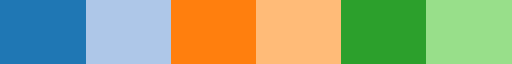

In [122]:
custom_cmap

Using tSNE


In [123]:
from sklearn.manifold import TSNE
X = data_corrected.values 
tSNE=TSNE(n_components=2)
tSNE_result=tSNE.fit_transform(X)
# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
x=tSNE_result[:,0]
y=tSNE_result[:,1]

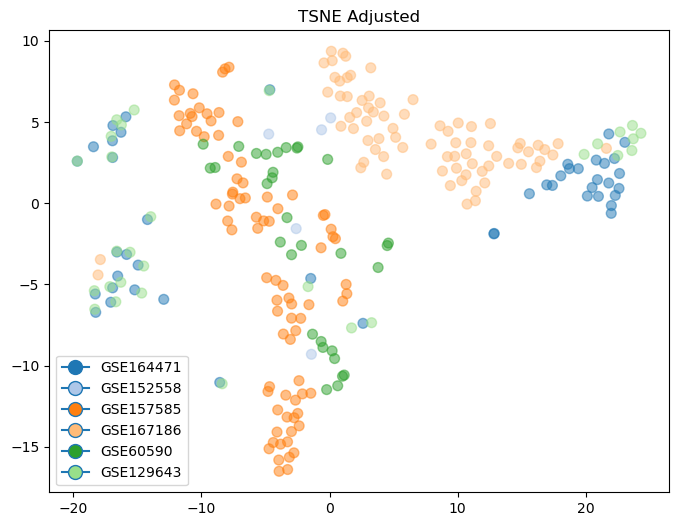

In [124]:

plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE Adjusted')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)

# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_Combat_by_experiment.png"
plt.savefig(save)

Using PCA

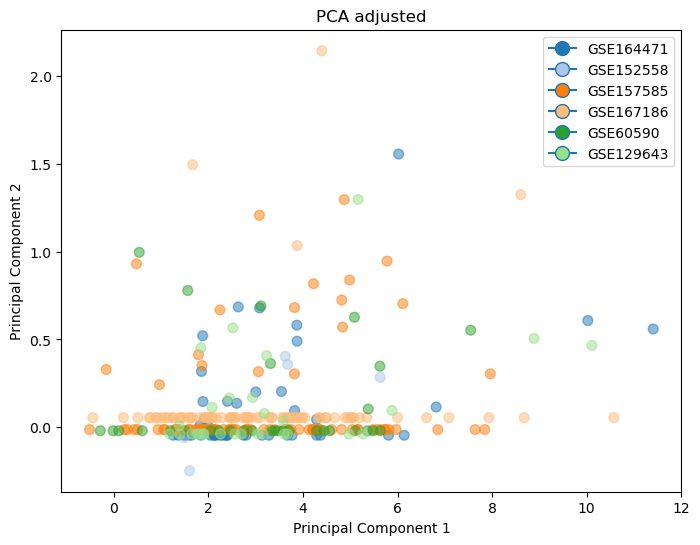

In [125]:

# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA adjusted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_Combat_by_experiment_double_nomr.png"
plt.savefig(save)

Lookign at the age

In [126]:



# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(age_order)}
category_map = {'Young': -1,  'MiddleAge': 0, 'Old': 1}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_age_order = [category_map[experiment] for experiment in age_order]
tab20_colors = plt.cm.tab10.colors
num_colors = len(np.unique(age_order))
colors = [tab20_colors[i] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)


In [127]:
pd.DataFrame(age_order).value_counts()

Old          135
Young         93
MiddleAge     42
Name: count, dtype: int64

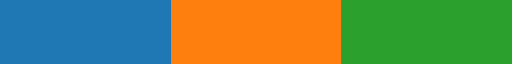

In [128]:
custom_cmap

tSNE

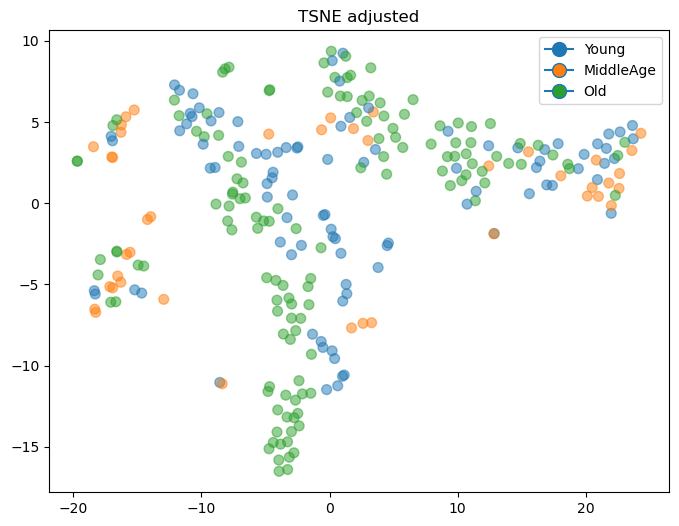

In [129]:

plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE adjusted')

# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_Combat_by_age_double_norm.png"
plt.savefig(save)
#plt.savefig("TSNE_Scatter_Plot_Age_reCombat.jpg")

PCA

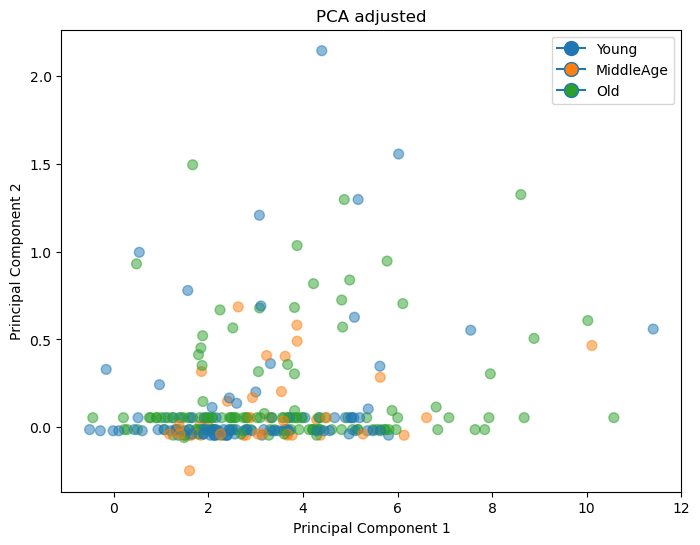

In [130]:

# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA adjusted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_Combat_by_age_double_norm.png"
plt.savefig(save)
# plt.savefig("PCA_Scatter_Plot_Age_reCombat.jpg")

Unadjusted

In [131]:
X = cts_processed.values 


tSNE by experiment

In [132]:

tSNE=TSNE(n_components=2)
tSNE_result=tSNE.fit_transform(X)
# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
x=tSNE_result[:,0]
y=tSNE_result[:,1]

In [133]:
# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(experiment_order)}
if technology =="RNAseq":
    category_map = {'GSE164471': -1, 'GSE152558': 0, 'GSE157585': 1, 'GSE167186':2, "GSE60590":3, "GSE129643":4}
elif technology == "microarray":
    category_map = {'GSE13070':-6, 'GSE47969':-5, 'GSE48278':-4, 'GSE9103':-3, 'GSE59880':-2, 'GSE9676':-1, 'GSE161643':0, 'GSE8157':1, 'GSE1428':2, 'GSE38718':3, 'GSE6348':4, 'GSE40551':5, 'GSE87105':6, 'GSE674_2':7}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_experiment_order = [category_map[experiment] for experiment in experiment_order]

from matplotlib.colors import ListedColormap
tab20_colors = plt.cm.tab20.colors
num_colors = len(np.unique(experiment_order))
colors = [tab20_colors[i ] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)

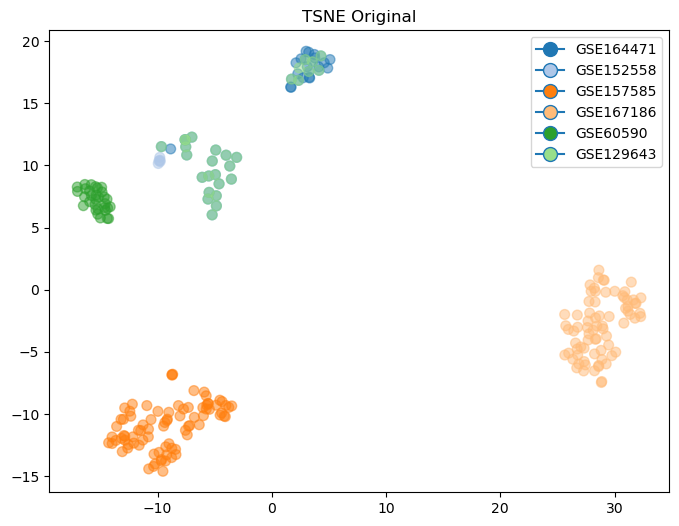

In [134]:

plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE Original')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)

# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_Original_by_experiment_double_norm.png"
plt.savefig(save)
#plt.savefig("TSNE_Scatter_Plot_Experiment_Original.jpg")

PCA by experiment original

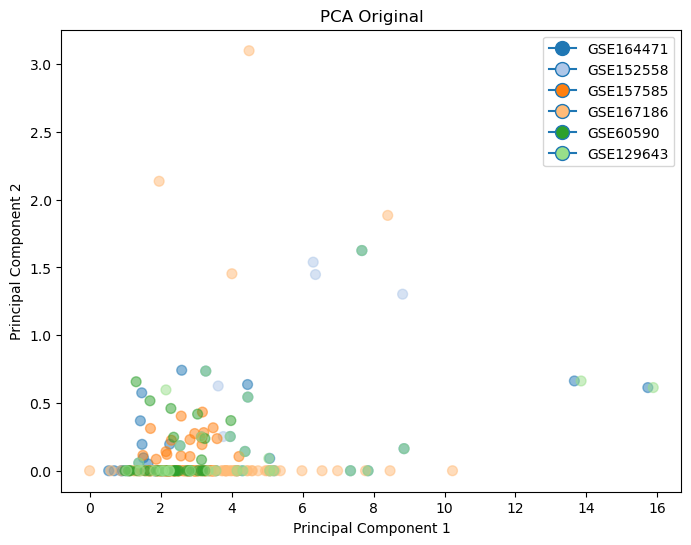

In [135]:

# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_experiment_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA Original')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_Original_by_experiment_double_norm.png"
plt.savefig(save)
#plt.savefig("PCA_Scatter_Plot_Experiment_Original.jpg")

By age

In [136]:

# Define a dictionary mapping categories to numerical values
category_map = {category: i for i, category in enumerate(age_order)}
category_map = {'Young': -1,  'MiddleAge': 0, 'Old': 1}
# Assuming you have a list called experiment_order which contains the experiment names
# Map the experiment names to numerical values
numeric_age_order = [category_map[experiment] for experiment in age_order]
tab20_colors = plt.cm.tab10.colors
num_colors = len(np.unique(age_order))
colors = [tab20_colors[i % 20] for i in range(num_colors)]
custom_cmap = ListedColormap(colors)

TSNE by age

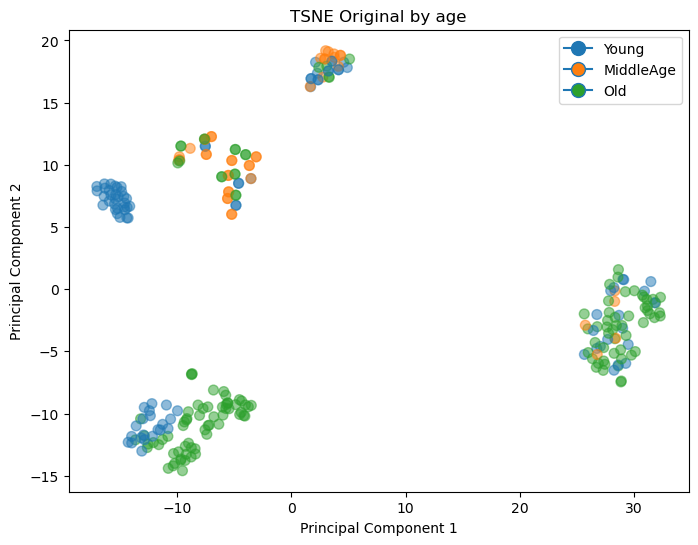

In [137]:


# Step 3: Visualize the clusters
# Plot the first two principal components and color them according to the assigned clusters
plt.figure(figsize=(8, 6))
plt.scatter(x,y, c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('TSNE Original by age')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/TSNE_Scatter_Plot_Experiment_{technology}_Original_by_age_double_norm.png"
plt.savefig(save)
#plt.savefig("TSNE_Scatter_Plot_Age_Original.jpg")

PCA by age original

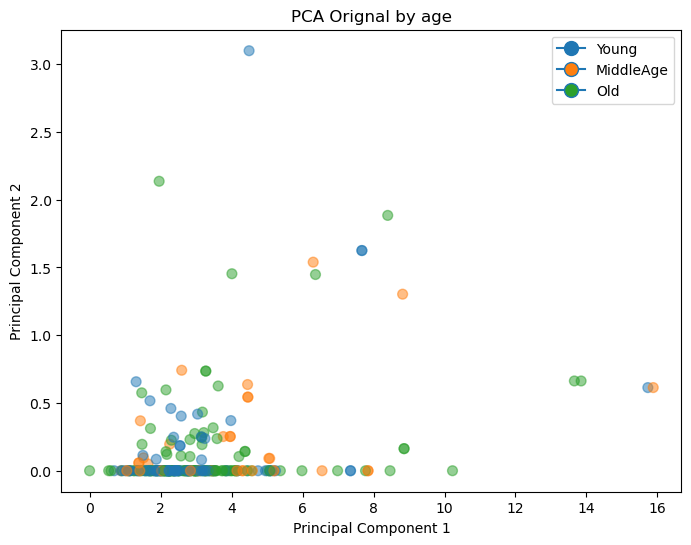

In [138]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=numeric_age_order, cmap=custom_cmap, s=50, alpha=0.5)
plt.title('PCA Orignal by age')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
#plt.colorbar(label="Experiment", spacing ="uniform",  values=numeric_experiment_order)


# Create legend with experiment names
legend_handles = [plt.Line2D([0], [0], marker='o',  markerfacecolor=color, markersize=10, label=f'Experiment {i+1}') for i, color in enumerate(colors)]
plt.legend(handles=legend_handles, labels=list(category_map.keys()), loc='best')

#plt.legend(list(category_map.keys()))
#plt.show()
save=f"/home/karen/Documents/phd/Plots/PCA_Scatter_Plot_Experiment_{technology}_Original_by_age_double_norm.png"
plt.savefig(save)
#plt.savefig("PCA_Scatter_Plot_Age_Original.jpg")

UMAP